In [9]:
cd ..

/home/mars/mount/src_aiai


In [10]:
import tqdm 

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
from scipy.special import iv, jv
from scipy.sparse import *

In [12]:
import sparse

In [13]:
from src.sampling.uv_sampling import spider_sampling

In [14]:
from src.operators.measurement import NUFFT_op

Failed to import NUDFT_cupy (experimental). Use NUDFT() instead. 


In [15]:
uv = spider_sampling()

In [16]:
nufft = NUFFT_op(uv)

In [17]:
Nd = (256,256)
Kd = (512, 512)

In [18]:
gridsize = 2*np.pi / Kd[0]
k = (uv + np.pi) / gridsize
kx = (uv[:,0] + np.pi) // gridsize
ky = (uv[:,1] + np.pi) // gridsize

In [19]:
def calculate_coef(k, i, Jd=(6,6)):
    k = k.reshape(-1,1)
    J = Jd[0]//2
    a = np.array(np.meshgrid(range(-J, J), range(-J, J))).reshape(2, -1)
    a += (k % 1 >0.5) # corrects to the closest 6 pixels
    indices = (k.astype(int) + a)

    J = np.linalg.norm(Jd) # composite J

    beta = 2.34*J
    norm = J #iv(0, beta) # TODO figure out which norm

    u = np.linalg.norm(k.reshape(2,1) - indices, axis=0) # 2d distance
    values = iv(0, beta*np.sqrt(1 +0j - (4*u/Jd[0])**2)).real / norm # 1/4 J because (sqrt((1/2 J)^2 + (1/2 J)^2 )= 1/4J)

    indices = np.vstack((np.zeros(indices.shape[1]), np.repeat(i, indices.shape[1]), indices[0], indices[1])).astype(int)

    return indices.T, values

In [20]:
c = calculate_coef(k[0], 0)

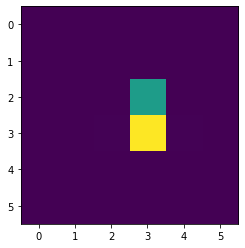

In [21]:
plt.imshow(c[-1].reshape(6,6))

In [22]:
class Op():
    def __init__(self):
        pass
        # TODO select axes over which to perform fft (and padding operations)
        # TODO add scaling 
        # TODO check coeficient calculation
        
    def plan(self, uv, Nd, Kd, Jd):
        # saving some values
        self.Nd = Nd
        self.Kd = Kd
        self.Jd = Jd
        self.M = len(uv)
        
        gridsize = 2*np.pi / Kd[0]
        k = (uv + np.pi) / gridsize
        
        # calculating coefficients for interpolation
        indices = []
        values =  []
        for i in tqdm.tqdm(range(len(uv))):
            ind, vals = calculate_coef(k[i], i, Jd)
            indices.append(ind)
            values.append(vals.real)
        
        indices = np.array(indices).reshape(-1, 4)
        values = np.array(values).reshape(-1)
        self.interp_matrix = sparse.COO(indices.T, values, shape=(1, len(uv), Kd[0], Kd[1]))
    
        J = np.linalg.norm(Jd)
        beta = 2.34*J
        xx, yy = np.mgrid[:Nd[0], :Nd[1]]
        
        xx = yy = np.linspace(-0.5, 0.5, Nd[0])
        
#         rr = np.sqrt( (xx- Nd[0]/2)**2 + (yy - Nd[1]/2)**2 )
        rr = np.sqrt( (xx.reshape(-1,1))**2 + (yy.reshape(1,-1))**2 )
        
        self.scaling = 1
        # TODO figure out how to scale the image domain
#         self.scaling = np.sqrt(np.pi**2 * (J**2 * rr**2 - beta**2 + 0j))/np.sin(np.sqrt(np.pi**2 * (J**2 * rr**2 - beta**2 + 0j)))
        
    def forward(self, xx):
        return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx*self.scaling).reshape(-1, self.Nd[0], self.Nd[1]))))) 
#         return np.squeeze(self._kk2k(self._xx2kk(self._pad((xx).reshape(-1, self.Nd[0], self.Nd[1]))*self.scaling))) 
    
    def adjoint(self, k):
        return np.squeeze(self._unpad(self._kk2xx(self._k2kk(k)))) / self.scaling
    
    def _kk2k(self, kk):
        """interpolates of the grid to non uniform measurements"""
        return (self.interp_matrix * kk.reshape(-1, 1, self.Kd[0], self.Kd[1])).sum(axis=(2,3)).todense()
    
    def _k2kk(self, y):
        """convolutes measurements to oversampled fft grid"""
        return (self.interp_matrix * y.reshape(-1, self.M, 1, 1)).sum(axis=1).todense()
    
    @staticmethod
    def _kk2xx(kk):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(kk, axes=(-2,-1)), axes=(-2,-1), norm='ortho'), axes=(-2,-1))

    @staticmethod
    def _xx2kk(xx):
        """from 2d fourier space to 2d image space"""
        return np.fft.fftshift(np.fft.fft2(np.fft.fftshift(xx, axes=(-2,-1)), axes=(-2,-1), norm='ortho'), axes=(-2,-1))
    
    def _pad(self, x):
        """pads x to go from Nd to Kd"""
        return np.pad(x, (
            ( 0,0 ),
            ( (self.Kd[0]-self.Nd[0])//2, (self.Kd[0]-self.Nd[0])//2),
            ( (self.Kd[1]-self.Nd[1])//2, (self.Kd[1]-self.Nd[1])//2)
            ))
    
    
    def _unpad(self, x):
        """unpads x to go from  Kd to Nd"""
        return x[
            :,
            (self.Kd[0]-self.Nd[0])//2: (self.Kd[0]-self.Nd[0])//2 +self.Nd[0],
            (self.Kd[1]-self.Nd[1])//2: (self.Kd[1]-self.Nd[1])//2 +self.Nd[1]
            ] # remove zero padding from image

In [23]:
op = Op()
op.plan(uv, Nd=(256,256), Kd=(512,512), Jd=(6,6))

100%|██████████| 4440/4440 [00:00<00:00, 5415.98it/s]


TypeError: Invalid shape () for image data

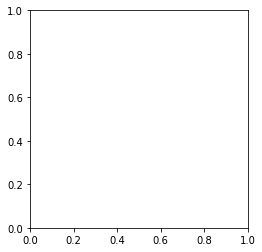

In [24]:
plt.imshow(op.scaling.real)
plt.colorbar()

In [38]:
x = np.ones((5, 256,256))

In [39]:
y = op.forward(x)

In [277]:
x_dirty = op.adjoint(np.ones_like(y))
# x_dirty = op.adjoint((y))

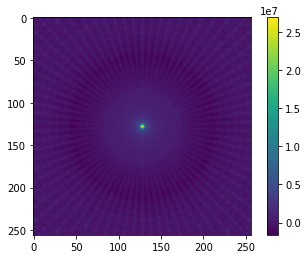

In [278]:
plt.imshow(x_dirty.real)
plt.colorbar()

In [279]:
x_dirty_2 = nufft.adj_op(np.ones_like(y))
# x_dirty_2 = nufft.adj_op((y))

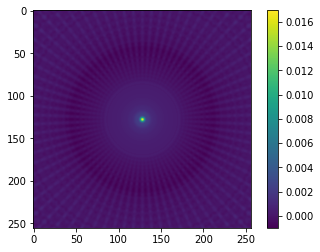

In [280]:
plt.imshow(x_dirty_2.real)
plt.colorbar()

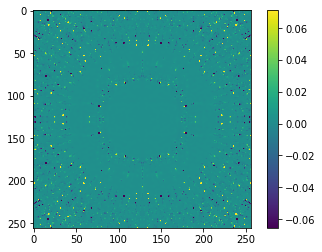

In [125]:
r = x_dirty_2.real/x_dirty.real
m = np.mean(r)
s = np.std(r)
plt.imshow(x_dirty_2.real/x_dirty.real, vmin=m-s, vmax=m+s)
plt.colorbar()

In [172]:
np.max(x_dirty.real), np.max(x_dirty_2.real), np.max(x_dirty.real)/np.max(x_dirty_2.real), np.max(x_dirty_2.real)/np.max(x_dirty.real)

(11.71255194332634, 0.016937248, 691.526253889314, 0.001446076695390455)

In [120]:
m, s

(0.002437879058026724, 0.04707311744075618)

In [127]:
np.close_to(x_dirty_2.real, x_dirty.real)

AttributeError: module 'numpy' has no attribute 'close_to'

In [129]:
Jd=(6,6)

In [261]:
J = np.linalg.norm(Jd)
beta = 2 #2.34*Jd[0]
xx, yy = np.mgrid[:Nd[0], :Nd[1]] 
xx = (xx - Nd[0]/2)/Kd[0]
yy = (yy - Nd[0]/2)/Kd[0]

# xx = yy = np.linspace(-0.5, 0.5, Nd[0])

#         rr = np.sqrt( (xx- Nd[0]/2)**2 + (yy - Nd[1]/2)**2 )
# rr = np.sqrt( (xx.reshape(-1,1))**2 + (yy.reshape(1,-1))**2 )

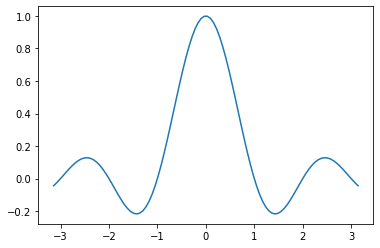

In [262]:
a = np.linspace(-np.pi, np.pi, 100)
b = np.sinc(a)
plt.plot(a,b)

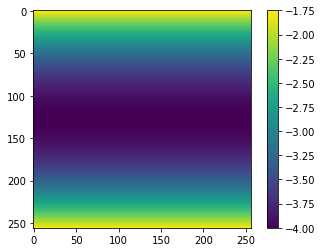

In [263]:
plt.imshow((Jd[0]*xx)**2 - beta**2)
plt.colorbar()

In [264]:
s1 = np.sqrt(np.pi**2 * (Jd[0]**2 * xx**2 - beta**2 + 0j))/np.sin(np.sqrt(np.pi**2 * (Jd[0]**2 * xx**2 - beta**2 + 0j)))
s2 = 1/np.sinc(np.sqrt(np.pi**2 * (Jd[0]**2 * yy**2 - beta**2 + 0j)))


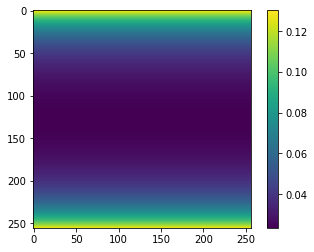

In [265]:
plt.imshow(s1.real)
plt.colorbar()

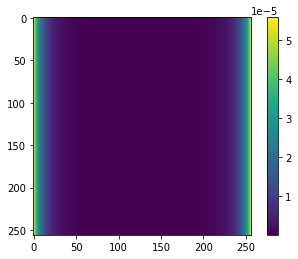

In [266]:
plt.imshow(s2.real)
plt.colorbar()

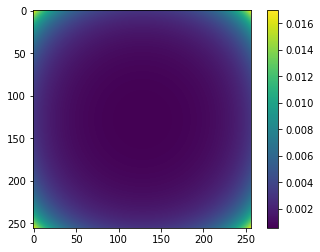

In [267]:
plt.imshow((s1 * s1.T).real)
plt.colorbar()

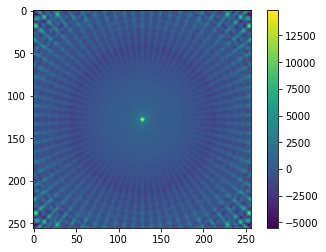

In [268]:
plt.imshow((s1 * s1.T).real*x_dirty.real)
plt.colorbar()

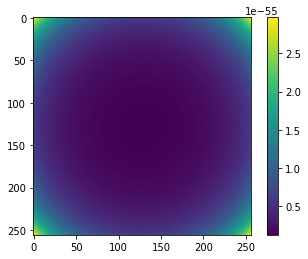

In [187]:
plt.imshow((s2 * s2.T).real)
plt.colorbar()

In [ ]:
class Gradient_2(tf.keras.layers.Layer):
    def __init__(self, m_op, shape, depth):
        self.m_op = m_op
        self.input_spec = [
            tf.keras.layers.InputSpec(
                dtype=tf.float32,
                shape=shape
            ),
            tf.keras.layers.InputSpec(
                dtype=tf.complex64,
                shape=shape
            )
        ]
        self.depth = depth +1
        self.trainable=False

In [78]:
forward = lambda x: tf.numpy_function(op.forward, [x], tf.complex128)
adjoint = lambda x: tf.numpy_function(op.adjoint, [x], tf.complex128)

In [79]:
def gradient(x, y):
    m = forward(x)
#     print(m)
    res = m - y
#     print(res)
    return tf.cast(adjoint(res), tf.float32)

In [56]:
a = tf.convert_to_tensor(np.ones((3,256,256,1)))
b = forward(a[:,:,:,0])
c = adjoint(b)

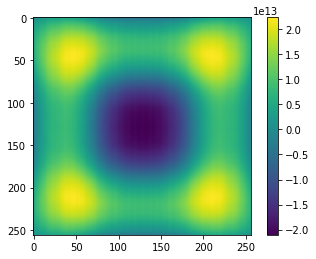

In [61]:
plt.imshow(c.numpy()[0].real)
plt.colorbar()

In [62]:
g = gradient(c,b).numpy()

tf.Tensor(
[[ 4.26130497e+20-2.16882333e+19j  5.05074054e+20-1.74894288e+19j
   2.51333027e+20-8.55611759e+18j ... -3.51318563e+17-3.31087464e+17j
  -4.26247227e+17-3.42522302e+17j -6.96107584e+17-3.19602526e+17j]
 [ 4.26130497e+20-2.16882333e+19j  5.05074054e+20-1.74894288e+19j
   2.51333027e+20-8.55611759e+18j ... -3.51318563e+17-3.31087464e+17j
  -4.26247227e+17-3.42522302e+17j -6.96107584e+17-3.19602526e+17j]
 [ 4.26130497e+20-2.16882333e+19j  5.05074054e+20-1.74894288e+19j
   2.51333027e+20-8.55611759e+18j ... -3.51318563e+17-3.31087464e+17j
  -4.26247227e+17-3.42522302e+17j -6.96107584e+17-3.19602526e+17j]], shape=(3, 4440), dtype=complex128)
tf.Tensor(
[[ 4.26130497e+20-2.16882333e+19j  5.05074054e+20-1.74894288e+19j
   2.51333027e+20-8.55611759e+18j ... -3.51318563e+17-3.31087464e+17j
  -4.26247227e+17-3.42522302e+17j -6.96107584e+17-3.19602526e+17j]
 [ 4.26130497e+20-2.16882333e+19j  5.05074054e+20-1.74894288e+19j
   2.51333027e+20-8.55611759e+18j ... -3.51318563e+17-3.3108746

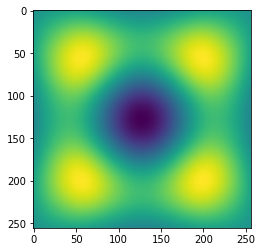

In [63]:
plt.imshow(g[0])

In [53]:
gradient(a,b).numpy().nonzero()

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [1]:
import tensorflow as tf

In [4]:
input_shape =(256,256,1)

In [72]:
grad.set_shape([None,256,256])

In [73]:
grad.shape

TensorShape([None, 256, 256])

In [87]:
inputs = tf.keras.Input(input_shape)
measurements = forward(inputs[:,:,:,0])

x = inputs

# grad = gradient(x[:,:,:,0], measurements)
# grad.set_shape([None,256,256])
# x = tf.keras.layers.Concatenate()([x,grad[:,:,:, None]])

x = tf.keras.layers.Conv2D(
            filters=4, 
            kernel_size=3, 
            activation='relu', 
            padding='same',
            name="conv2d_down_depth" )(x)

# output formatting
outputs = tf.keras.layers.Conv2D(
            filters=1, 
            kernel_size=1, 
            padding='same',
            activation='linear',
            name="conv2d_output"
            )(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss= tf.keras.losses.MSE)

In [88]:
inputs = tf.keras.Input(input_shape)
measurements = forward(inputs[:,:,:,0])

x = inputs

grad = gradient(x[:,:,:,0], measurements)
grad.set_shape([None,256,256])
x = tf.keras.layers.Concatenate()([x,grad[:,:,:, None]])

x = tf.keras.layers.Conv2D(
            filters=4, 
            kernel_size=3, 
            activation='relu', 
            padding='same',
            name="conv2d_down_depth" )(x)

# output formatting
outputs = tf.keras.layers.Conv2D(
            filters=1, 
            kernel_size=1, 
            padding='same',
            activation='linear',
            name="conv2d_output"
            )(x)

grad_model = tf.keras.Model(inputs=inputs, outputs=outputs)

grad_model.compile(optimizer='adam', loss= tf.keras.losses.MSE)

In [81]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_30 (Sl (None, 256, 256)     0           input_19[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_29 (Sl (None, 256, 256)     0           input_19[0][0]                   
__________________________________________________________________________________________________
tf.numpy_function_33 (TFOpLambd None                 0           tf.__operators__.getitem_30[0][0]
____________________________________________________________________________________________

In [82]:
def load_data(data_folder, ISNR=30):
    """load the pre-computed train and test data"""
    fft = lambda x: np.fft.fftshift(np.fft.fft2(
        np.fft.fftshift(x, axes=(1,2)), axes=(1,2), norm='ortho'), axes=(1,2))

    print("Loading train data")
    x_true = np.load(data_folder+ f"/x_true_train_{ISNR}dB.npy")
    x_dirty = np.load(data_folder+ f"/x_dirty_train_{ISNR}dB.npy")
    # y_dirty = np.load(project_folder + f"./data/intermediate/{data}/y_dirty_train_{ISNR}dB.npy").reshape( 200,4440)
    


    return x_true, x_dirty


In [ ]:
# x_true, x_dirty = load_data("./data/intermediate/BSDS/", 50)


In [89]:
model.fit((x_dirty), x_true, epochs=5)

Epoch 1/5
7/7 [==============================] - 1s 172ms/step - loss: 0.2655
Epoch 2/5
7/7 [==============================] - 1s 159ms/step - loss: 0.2512
Epoch 3/5
7/7 [==============================] - 1s 159ms/step - loss: 0.2358
Epoch 4/5
7/7 [==============================] - 1s 166ms/step - loss: 0.2376
Epoch 5/5
7/7 [==============================] - 1s 162ms/step - loss: 0.2184


In [90]:
grad_model.fit((x_dirty), x_true, epochs=5)

Epoch 1/5
7/7 [==============================] - 19s 3s/step - loss: 0.2754
Epoch 2/5
7/7 [==============================] - 18s 3s/step - loss: 0.2653
Epoch 3/5
7/7 [==============================] - 18s 3s/step - loss: 0.2437
Epoch 4/5
7/7 [==============================] - 18s 3s/step - loss: 0.2390
Epoch 5/5
7/7 [==============================] - 18s 3s/step - loss: 0.2290


In [ ]:
# with gradient: 3s/32
# without gradient: 163ms/32

In [102]:
indices = [
    [0,0,0],
    [1,1,1],
]

values = [1,2]
dense_shape = [2,3,3]

In [103]:
a = tf.sparse.SparseTensor(indices, values, dense_shape)

In [111]:
b = tf.convert_to_tensor(3*np.ones((3,3),dtype=np.int32))

In [122]:
op.interp_matrix.coords.shape

(4, 159840)

In [112]:
tf.sparse.to_dense(a)

<tf.Tensor: shape=(2, 3, 3), dtype=int32, numpy=
array([[[1, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 2, 0],
        [0, 0, 0]]], dtype=int32)>

In [113]:
tf.sparse.to_dense(a*b)

<tf.Tensor: shape=(2, 3, 3), dtype=int32, numpy=
array([[[3, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 6, 0],
        [0, 0, 0]]], dtype=int32)>

In [134]:
indices = op.interp_matrix.coords
values = op.interp_matrix.data
dense_shape = op.interp_matrix.shape

In [135]:
indices.shape, values.shape, dense_shape

((4, 159840), (159840,), (1, 4440, 512, 512))

In [136]:
values

array([-0.01236364, -0.00135298, -0.01566847, ..., -0.00369519,
       -0.00692111,  0.00567517])

In [138]:
a = tf.sparse.SparseTensor(indices.T, values, dense_shape)

In [140]:
b = tf.convert_to_tensor(np.ones((512,512),dtype=float))

In [145]:
c = tf.sparse.reduce_sum(a*b, axis=1)

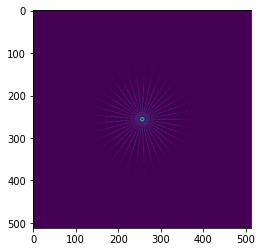

In [151]:
plt.imshow(c.numpy()[0])